### Evaluation of models on the test set (for CIFAR) 
generation of figures in the MICCAI paper (for CIFAR, TMED, and AS)

and visualization of individual CIFAR images along their predictions

In [1]:
import os
import numpy as np
import pandas as pd
import glob
import re
from scipy.special import softmax

from scipy.io import loadmat
from skimage.transform import resize
from sklearn.metrics import f1_score, confusion_matrix, balanced_accuracy_score, accuracy_score
import matplotlib
import matplotlib.pyplot as plt

from platt_scaling import platt_scaling_fit
from conformal_pred_algos import *
from conformal_pred_metrics import *

In [19]:
# experimental settings
dataset = 'CIFAR'
MAP_TO_STUDY_LEVEL = False
ALPHA = 0.05

In [3]:
# start by obtaining, for each method, the validation and test prediction logits

methods = ['CE', 'CE+RT4U', 'MAE', 'ANL']
log_root = '../logs/'
val_csvs = ['R18_cifar_smaller_val/round0/csvs/val_2_0.75.csv', 'R18_cifar_smaller_val/round1/csvs/val_8_0.77.csv', 'cifar_mae/csvs/val_9_0.74.csv', 'cifar_anl_ce/csvs/val_9_0.74.csv']
test_csvs = ['R18_cifar_smaller_val/round0/csvs/test_10_0.74.csv', 'R18_cifar_smaller_val/round1/csvs/test_10_0.76.csv', 'cifar_mae/csvs/test_10_0.74.csv', 'cifar_anl_ce/csvs/test_10_0.73.csv']


# # Deprecated selection for TMED/AS 
# # Please refer to other evaluation scripts for the more up-to-date evaluation methods for the other datasets
# # This part can still be used to generate the calibration/certainty histogram figures for other datasets
# if dataset == 'TMED':
#     methods = ['Default', 'LE=1', 'LE=2']
#     log_root = "../logs/R18_tmed/"
#     val_csvs = ["round0/csvs/val_6_0.59.csv", "round1/csvs/val_18_0.59.csv", "round2/csvs/val_15_0.60.csv"]
#     test_csvs = ["round0/csvs/test_30_0.55.csv", "round1/csvs/test_30_0.55.csv", "round2/csvs/test_30_0.57.csv"]
# elif dataset == 'CIFAR':
#     methods = ['CE', 'CE+RT4U', 'MAE', 'ANL']
#     log_root = '../logs/'
#     val_csvs = ['R18_cifar_smaller_val/round0/csvs/val_2_0.75.csv', 'R18_cifar_smaller_val/round1/csvs/val_8_0.77.csv', 'cifar_mae/csvs/val_9_0.74.csv', 'cifar_anl_ce/csvs/val_9_0.74.csv']
#     test_csvs = ['R18_cifar_smaller_val/round0/csvs/test_10_0.74.csv', 'R18_cifar_smaller_val/round1/csvs/test_10_0.76.csv', 'cifar_mae/csvs/test_10_0.74.csv', 'cifar_anl_ce/csvs/test_10_0.73.csv']
# elif dataset == 'AS':
#     methods = ['R(2+1)D', 'R(2+1)D+RT4U']
#     log_root = '../logs/AS_Prev/'
#     val_csvs = ['round0/csvs/val_17.csv', 'round1/csvs/val_13.csv']
#     test_csvs = ['round0/csvs/test_0.csv', 'round1/csvs/test_0.csv']
#     data_info_df = pd.read_csv("../logs/AS_Prev/annotations-all.csv")
#     data_info_df['base_id'] = data_info_df['path'].apply(os.path.basename)

val_csvs = [log_root + m for m in val_csvs]
test_csvs = [log_root + m for m in test_csvs]

In [4]:
# collect the dataframes
df_val = [pd.read_csv(x).sort_values(by=['filename']).reset_index() for x in val_csvs]
df_test = [pd.read_csv(x).sort_values(by=['filename']).reset_index() for x in test_csvs]

In [5]:
df_val[0]

,index,Unnamed: 0,filename,y,outputs_0,outputs_1,outputs_2,outputs_3,outputs_4,outputs_5,outputs_6,outputs_7,outputs_8,outputs_9
0,0,0,0,2,-3.001708,-3.576829,1.961566,2.532536,1.490982,1.187150,4.152256,-0.315097,-3.347448,-6.132422
1,1,1,1,2,-5.085364,-2.291695,1.710982,3.207811,2.806079,2.597799,2.508767,-0.193195,-6.172404,-4.230563
2,2,2,2,2,-1.083707,-2.971695,4.539859,0.282981,2.148135,1.377571,-1.043147,-1.375022,-3.449902,-2.822930
3,3,3,3,2,-0.613623,-2.375404,6.087807,-1.348315,1.907314,0.004485,1.560015,-2.022348,-2.452760,-5.200134
4,4,4,4,9,1.994644,0.411160,-2.455649,-2.071070,-4.160336,-2.869025,-4.015794,1.097073,1.004520,6.329980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,9995,9995,1,0.195229,13.884732,-3.641811,-2.303909,-2.230237,-2.974793,-5.790798,-1.826558,-0.143492,2.644449
9996,9996,9996,9996,1,3.491110,4.470566,-4.962294,-2.465844,-5.342498,-4.389783,-7.842149,-0.777049,3.676502,9.883956
9997,9997,9997,9997,1,3.829250,3.754202,-3.131140,-2.295289,-2.423538,-2.705829,-6.408394,0.513103,3.535192,3.680714
9998,9998,9998,9998,1,4.350280,3.105906,1.520656,1.144718,-3.755720,0.959710,-5.070094,-3.218049,1.852301,-3.228741


### Preprocessing: extracting logits, grouping into study-level if requested

In [6]:
def studyinfo_from_query_key(s):
    # Define the regular expression pattern
    pattern = r'(\d+)s(\d+)_(\d+)\.png'
    
    # Use re.match to search for the pattern in the string
    match = re.match(pattern, s)
    
    # If a match is found, extract the groups and return them as a tuple
    if match:
        ID, studyNum, imageNum = match.groups()
        #return int(ID), int(studyNum), int(imageNum)
        return str(ID) + '_' + str(studyNum)
    else:
        return None
    
def search_for_study_id_AS(uid):
    # look for uid match in the AS database, then find the echo ID#
    base_id = os.path.basename(uid)
    row = data_info_df[data_info_df['base_id']==base_id]['Echo ID#']
    if len(row) > 1:
        print(row)
        assert False
    return int(row.values[0])

def find_study_id(uids, mode='TMED'):
    # uids is a pd.series of unique identifiers
    # returns a pd.series of study IDs
    if mode == 'TMED':
        basenames = uids.apply(os.path.basename)
        study_nums = basenames.apply(studyinfo_from_query_key)
    elif mode == 'CIFAR':
        study_nums = uids // 4
    elif mode == 'AS':
        study_nums = uids.apply(search_for_study_id_AS)
    return study_nums

find_study_id(df_val[0]['filename'], mode=dataset).unique()

array([   0,    1,    2, ..., 2497, 2498, 2499])

In [7]:
def group_logits_by_study(df, mode='TMED'):
    cols = [x for x in df.columns if 'outputs' in x]
    new_df = {'y':[], 'uid':[]}
    for c in cols:
        new_df[c] = []
    
    study_nums = find_study_id(df['filename'], mode=mode)
    for s in study_nums.unique():
        dfs = df[study_nums == s]
        new_df['y'].append(dfs.iloc[0]['y'])
        new_df['uid'].append(s)
        # average the logits
        for c in cols:
            new_df[c].append(np.mean(dfs[c]))
            
    return pd.DataFrame.from_dict(new_df)

if MAP_TO_STUDY_LEVEL:
    df_val = [group_logits_by_study(v, dataset) for v in df_val]
    df_test = [group_logits_by_study(v, dataset) for v in df_test]


In [8]:
def df_to_logits(df):
    # take the outputs_x rows and conver them to array of (N, C)
    cols = [x for x in df.columns if 'outputs' in x]
    logits = df[cols].to_numpy()
    return logits

test_logits = [df_to_logits(x) for x in df_test]
val_logits = [df_to_logits(x) for x in df_val]

In [9]:
# This function is used for the AS dataset but not others
# It specifically combines a 4-way prediction (no/mild/mod/sev AS) into 3-way prediction (no/mild/mod+sev AS)
def group_modsev(data):
    # if data is (N,), assume this is the class label, in which the class label 3 becomes 2
    # if data is (N, C), assume this is the preds, in which case pred[:, 2] = pred[:, 2] + pred[:, 3]
    N = data.shape
    if len(N) == 1:
        data = data
        data[data==3] = 2
        return data
    else:
        N, C = data.shape
        if C == 4:
            data[:, 2] = data[:, 2] + data[:, 3]
            return data[:, :3]
        else:
            return data
        
def group_modsev_batch(list_data):
    list_outs = [group_modsev(x) for x in list_data]
    return list_outs

### Balanced Accuracy

In [10]:
# compute the top-1 balanced accuracy
for i in range(len(methods)):
    val_gt, test_gt = df_val[i]['y'], df_test[i]['y']
    val_pred = np.argmax(val_logits[i], axis=1)
    test_pred = np.argmax(test_logits[i], axis=1)
    if dataset == "AS":
        val_gt, test_gt, val_pred, test_pred = group_modsev_batch([val_gt, test_gt, val_pred, test_pred])
    val_acc = balanced_accuracy_score(val_gt, val_pred)
    test_acc = balanced_accuracy_score(test_gt, test_pred)
    print(f"Method: {methods[i]}, balanced top-1 acc (val/test) = {val_acc}/{test_acc}")
    print(confusion_matrix(val_gt, val_pred))
    print(confusion_matrix(test_gt, test_pred))

Method: CE, balanced top-1 acc (val/test) = 0.7504196928801212/0.7431
[[794   6  31  14  13   2   4  11  65  36]
 [ 44 796   3  14   5   8   3  11  30  74]
 [ 52   7 595  70  65  39  48  33  20   7]
 [ 22   4  37 743  35 148  48  22   9  12]
 [ 13   0  57  34 635  26  40  61   7   3]
 [  9   2  31 190  38 659  15  49   5   6]
 [  8   1  52  54  41  13 817   8  11   3]
 [  8   1  40  34  84  49   7 719   9  13]
 [ 88  30   8  18  10   5   6  11 910  50]
 [ 30  65   7  12   9   4   7  19  30 849]]
[[3160   40  129   71   59   29   29   64  265  154]
 [ 136 3177   31   55   34   22   19   30  116  380]
 [ 215   13 2617  266  328  154  240   88   53   26]
 [ 102   35  186 2613  153  498  176  139   49   49]
 [  54    9  247  188 2919  144  195  184   47   13]
 [  44   16  130  733  170 2603   82  169   25   28]
 [  38   14  200  236  189   78 3190   23   18   14]
 [  64   18  116  185  320  175   35 3007   33   47]
 [ 344   84   43   56   58   19   22   36 3144  194]
 [ 139  229   14   67 

### Calibration of predictions

In [11]:
def get_calibration_data(sm, y):
    # sm is N, C softmax output
    # compute the accuracy of each confidence decile
    confidences = np.max(sm, axis=1)
    preds = np.argmax(sm, axis=1)
    #print(confidences)
    confidence_hist, bin_edges = np.histogram(confidences, bins=np.arange(11)/10)
    #print(confidence_hist)
    #print(bin_edges)
    bin_association = np.digitize(confidences, bins=bin_edges)
    #print(np.unique(bin_association))
    calibration_x = []
    calibration_y = []
    ECE = 0
    for i in range(10):
        subset = bin_association == (i+1)
        if confidence_hist[i] > 0: # and i > 2:
            acc = accuracy_score(y[subset], preds[subset])
            
            calibration_x.append(i/10 + 0.05)
            calibration_y.append(acc)
            #print(np.mean(confidences[subset]))
            # calculate ECE
            ECE += confidence_hist[i] * np.abs(acc - np.mean(confidences[subset]))
    ECE = ECE / len(y)
    
    return calibration_x, calibration_y, ECE
    
# sanity check: calibrating on yourself gets a low ECE
platt_coeffs = platt_scaling_fit(val_logits[0], df_val[0]['y'], mode="temp")
vsm = softmax(val_logits[0], axis=1)
vsm_platt = softmax(val_logits[0]*platt_coeffs, axis=1)
get_calibration_data(vsm_platt, df_val[0]['y'])

([0.15000000000000002,
  0.25,
  0.35,
  0.45,
  0.55,
  0.65,
  0.75,
  0.8500000000000001,
  0.9500000000000001],
 [0.3333333333333333,
  0.3054187192118227,
  0.35725429017160687,
  0.47126436781609193,
  0.5440647482014388,
  0.6328205128205128,
  0.7667304015296367,
  0.8438247011952191,
  0.9697766097240473],
 0.008315374643509938)

In [12]:
# compute the top-1 calibration
cal_x_arr, cal_y_arr, ece_arr = [], [], []
for i in range(len(methods)):
    platt_coeffs = platt_scaling_fit(val_logits[i], df_val[i]['y'], mode="temp")
    test_sm = softmax(test_logits[i], axis=1)
    test_sm_platt = softmax(test_logits[i]*platt_coeffs, axis=1)
    
    cal_x, cal_y, ece = get_calibration_data(test_sm, df_test[i]['y'])
    cal_x_arr.append(cal_x)
    cal_y_arr.append(cal_y)
    ece_arr.append(ece)
    
    cal_x, cal_y, ece_platt = get_calibration_data(test_sm_platt, df_test[i]['y'])
    cal_x_arr.append(cal_x)
    cal_y_arr.append(cal_y)
    ece_arr.append(ece_platt)
    print(f"Method {methods[i]}, ECE wo Platt: {ece} ECE w Platt: {ece_platt}")

Method CE, ECE wo Platt: 0.036680457742955475 ECE w Platt: 0.005181141484868694
Method CE+RT4U, ECE wo Platt: 0.03949963739230159 ECE w Platt: 0.06578128072645704
Method MAE, ECE wo Platt: 0.212602006906369 ECE w Platt: 0.010751652299437538
Method ANL, ECE wo Platt: 0.45154464869327304 ECE w Platt: 0.023959118399914173


['CE, ECE=0.037', 'CE+Temp, ECE=0.005', 'CE+RT4U, ECE=0.039', 'CE+RT4U+Temp, ECE=0.066', 'MAE, ECE=0.213', 'MAE+Temp, ECE=0.011', 'ANL, ECE=0.452', 'ANL+Temp, ECE=0.024']
[0.15000000000000002, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.8500000000000001, 0.9500000000000001]
[0.2222222222222222, 0.23865546218487396, 0.3410931174089069, 0.43025309005297235, 0.49299649824912456, 0.6007442849548112, 0.679379274066281, 0.7931246163290362, 0.9537690731040765]
[0.15000000000000002, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.8500000000000001, 0.9500000000000001]
[0.2, 0.26043956043956046, 0.36199095022624433, 0.45420974889217136, 0.5456696639848556, 0.6367041198501873, 0.7530864197530864, 0.8481188118811881, 0.9650899400399734]
[0.15000000000000002, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.8500000000000001, 0.9500000000000001]
[0.1935483870967742, 0.27547169811320754, 0.38130217028380636, 0.47362195410456587, 0.6030262572318648, 0.7142177841179268, 0.8191657271702367, 0.9081808767690714, 0.9821288603229347]

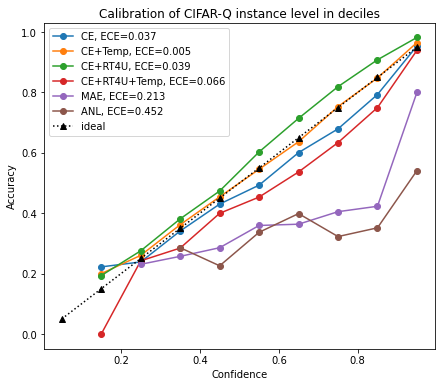

In [13]:
matplotlib.rcParams.update({'font.size': 12})
def plot_calibration(x_arr, y_arr, names):
    plt.figure(figsize=(7,6))
    legend_names = []
    for i in range(len(x_arr)):
        if i in [0, 1, 2, 3, 4, 6]:
            print(x_arr[i])
            print(y_arr[i])
            plt.plot(x_arr[i], y_arr[i], marker='o')
            legend_names.append(names[i])
    plt.plot(np.arange(10)/10 + 0.05, np.arange(10)/10 + 0.05, marker='^', linestyle='dotted', color='black')
    plt.legend(legend_names + ['ideal'])
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.title('Calibration of CIFAR-Q instance level in deciles')
    plt.show()
    
names = []
for i in range(len(ece_arr)):
    method = methods[i//2]
    ece = ece_arr[i]
    if i % 2 == 0:
        names.append("{}, ECE={:.3f}".format(method, ece))
    else:
        names.append("{}+Temp, ECE={:.3f}".format(method, ece))
print(names)
plot_calibration(cal_x_arr, cal_y_arr, names)

### Creating conformal prediction sets

In [14]:
# Conformal prediction using LABEL
for i in range(len(methods)):
    print(methods[i])
    y_test = df_test[i]['y'].to_numpy(dtype=int)
    y_val = df_val[i]['y'].to_numpy(dtype=int)
    platt_coeffs = platt_scaling_fit(val_logits[i], y_val, mode="temp")
    
    val_sm = softmax(val_logits[i], axis=1)
    val_sm_platt = softmax(val_logits[i]*platt_coeffs, axis=1)
    
    test_sm = softmax(test_logits[i], axis=1)
    test_sm_platt = softmax(test_logits[i]*platt_coeffs, axis=1)
    
    if dataset == "AS":
        y_val, y_test, val_sm, test_sm, val_sm_platt, test_sm_platt = group_modsev_batch([y_val, y_test, val_sm, test_sm, val_sm_platt, test_sm_platt])
    
    
    # evaluate 
    cov, bcov, card = develop_coverage_distribution(y_test, test_sm, n_splits=100, test_size=0.5, alpha=ALPHA)
    
    print(f"cov: {np.median(cov)}, {np.std(cov)}")
    print(f"bcov: {np.median(bcov)}, {np.std(bcov)}")
    print(f"card: {np.median(card)}, {np.std(card)}")
    #eff = [bcov[i]/card[i] for i in range(len(card))]
    #print(f"eff: {np.median(eff)}, {np.std(eff)}")
    
    
# # Deprecated version of evaluation which only performs one split of the conformal prediction
#     if calibrate:
#         #qhat = group_APS_fit(y_val, y_val, val_sm_platt, alpha=a, verbose=False)
#         #cs = group_APS_inference(test_sm_platt, y_test, qhat)
#         qhat = LABEL_fit(y_val, val_sm_platt, alpha=alpha, verbose=False)
#         cs = LABEL_inference(test_sm_platt,  qhat)
#     else:
#         #qhat = group_APS_fit(y_val, y_val, val_sm, alpha=a, verbose=False)
#         #cs = group_APS_inference(test_sm, y_test, qhat)
#         qhat = LABEL_fit(y_val, val_sm, alpha=alpha, verbose=False)
#         cs = LABEL_inference(test_sm,  qhat)

#     cov = coverage_test(y_test, cs)
#     bcov = balanced_coverage_test(y_test, cs)
#     card = cardinality_test(cs)
#     if dataset != 'CIFAR':
#         print(ordinality_test_arr(cs))
#     print(f"Calibrate({calibrate}): cov={cov}, bcov={bcov}, card={card}, efficiency={bcov/card}")
        

CE
cov: 0.9003, 0.0031345230498434702
bcov: 0.9003109613788933, 0.003132667593375148
card: 1.75155, 0.014530689754791413
CE+RT4U
cov: 0.8996999999999999, 0.002971867089894834
bcov: 0.8996942431022574, 0.002971797491962381
card: 1.628025, 0.013512671830544835
MAE
cov: 0.9004, 0.003066981048197068
bcov: 0.900381174742074, 0.0030608585574986363
card: 1.998125, 0.0198596413046661
ANL
cov: 0.9277249999999999, 0.007658287586007724
bcov: 0.9277029352628122, 0.007627711797796514
card: 4.198925, 0.49880295551850934


In [15]:
# visualize the distribution of gt class probability for the different studies
gt_confidences = []
for i in range(len(methods)):
    print(methods[i])
    y_test = df_test[i]['y'].to_numpy(dtype=int)
    y_val = df_val[i]['y'].to_numpy(dtype=int)
    N = len(y_test)
    
    platt_coeffs = platt_scaling_fit(val_logits[i], y_val, mode="temp")
    print(platt_coeffs)
    
    val_sm = softmax(val_logits[i], axis=1)
    val_sm_platt = softmax(val_logits[i]*platt_coeffs, axis=1)
    
    test_sm = softmax(test_logits[i], axis=1)
    test_sm_platt = softmax(test_logits[i]*platt_coeffs, axis=1)
    
    if dataset == "AS":
        y_val, y_test, val_sm, test_sm, val_sm_platt, test_sm_platt = group_modsev_batch([y_val, y_test, val_sm, test_sm, val_sm_platt, test_sm_platt])
    
    #gt_confidences.append(test_sm[range(N), y_test])
    #gt_confidences.append(test_sm_platt[range(N), y_test])
    gt_confidences.append(np.max(test_sm, axis=1))
    gt_confidences.append(np.max(test_sm_platt, axis=1)) 

CE
[0.8779026]
CE+RT4U
[1.1929216]
MAE
[0.24073601]
ANL
[0.06684387]


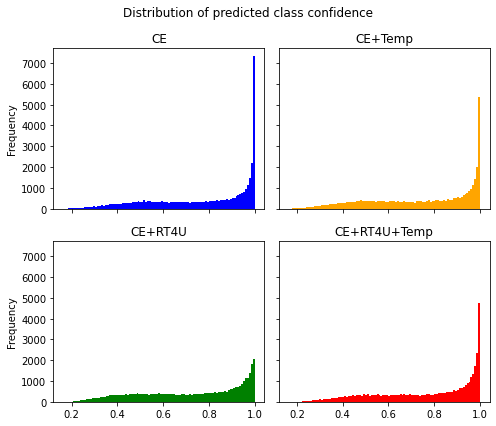

In [16]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, layout="tight", figsize=(7,6))
axs[0, 0].hist(gt_confidences[0], bins=99, color='blue')
axs[0, 0].set_title('CE')
axs[0, 0].set_ylabel('Frequency')

axs[0, 1].hist(gt_confidences[1], bins=99, color='orange')
axs[0, 1].set_title('CE+Temp')

axs[1, 0].hist(gt_confidences[2], bins=99, color='green')
axs[1, 0].set_title('CE+RT4U')
axs[1, 0].set_ylabel('Frequency')

axs[1, 1].hist(gt_confidences[3], bins=99, color='red')
axs[1, 1].set_title('CE+RT4U+Temp')

plt.suptitle('Distribution of predicted class confidence')

plt.show()


In [17]:
# random assert to make sure you aren't progressing forward on the next part which is only compatible with CIFAR dataset
assert False

AssertionError: 

In [20]:
# collect the predictions for each example
confidences, confidences_platt, pred_classes, css, css_platt = [], [], [], [], []

for i in range(len(methods)):
    print(methods[i])
    y_test = df_test[i]['y'].to_numpy(dtype=int)
    y_val = df_val[i]['y'].to_numpy(dtype=int)
    N = len(y_test)
    
    platt_coeffs = platt_scaling_fit(val_logits[i], y_val, mode="temp")
    
    val_sm = softmax(val_logits[i], axis=1)
    val_sm_platt = softmax(val_logits[i]*platt_coeffs, axis=1)
    
    test_sm = softmax(test_logits[i], axis=1)
    test_sm_platt = softmax(test_logits[i]*platt_coeffs, axis=1)
    
    if dataset == "AS":
        y_val, y_test, val_sm, test_sm, val_sm_platt, test_sm_platt = group_modsev_batch([y_val, y_test, val_sm, test_sm, val_sm_platt, test_sm_platt])
    
    confidences.append(test_sm)
    confidences_platt.append(test_sm_platt)
    pred_classes.append(np.argmax(test_sm, axis=1))
    
    qhat = LABEL_fit(y_val, val_sm, alpha=ALPHA, verbose=False)
    cs = LABEL_inference(test_sm,  qhat)
    css.append(cs)
    
    qhat = LABEL_fit(y_val, val_sm_platt, alpha=ALPHA, verbose=False)
    cs = LABEL_inference(test_sm_platt,  qhat)
    css_platt.append(cs)

CE
CE+RT4U
MAE
ANL


In [21]:
def show_inference_data(index, verbose=False):
    name = df_test[0]['filename'][index]
    label = df_test[0]['y'][index]
    class_mapping = np.array(['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
    print(f"Name: {name}, GT: {class_mapping[label]}")
    for i in range(2):
        conformal_set = css[i][index]
        indices = np.where(conformal_set)[0]
        local_conf = confidences[i][index][indices]
        conformal_set_p = css[i][index]
        indices_p = np.where(conformal_set_p)[0]
        local_conf_p = confidences_platt[i][index][indices_p]
        if verbose:
            print(f"Method {methods[i]}, classes = {class_mapping[indices]}, confidences = {local_conf}, cl_platt = {class_mapping[indices_p]}, conf_platt = {local_conf_p}")
    return

show_inference_data(0, True)

Name: 0, GT: cat
Method CE, classes = ['cat'], confidences = [0.9447756], cl_platt = ['cat'], conf_platt = [0.9054943]
Method CE+RT4U, classes = ['cat'], confidences = [0.90443935], cl_platt = ['cat'], conf_platt = [0.94604732]


In [30]:
N = len(pred_classes[0])
ce_pred = pred_classes[0]
rt_pred = pred_classes[1]
gt = df_test[0]['y'].to_numpy(dtype=int)
cond = (gt != rt_pred) & (gt != ce_pred)

selected = np.where(cond)[0]
# sort where by the discrepancy between predictions for the right class
confidence_differences = confidences_platt[1][range(N), gt] - confidences_platt[0][range(N), gt]
confidence_differences = confidence_differences[selected]
#selected = selected[np.argsort(-confidence_differences)]
print(selected)
print(len(selected))

count = 0
for i in selected:
    if count < 10:
        print('-----')
        show_inference_data(i, True)
        count += 1

[    8    30    36 ... 39982 39986 39994]
7353
-----
Name: 8, GT: ship
Method CE, classes = ['car'], confidences = [0.99731834], cl_platt = ['car'], conf_platt = [0.99317833]
Method CE+RT4U, classes = ['car' 'ship'], confidences = [0.84409241 0.09474205], cl_platt = ['car' 'ship'], conf_platt = [0.88804768 0.0718792 ]
-----
Name: 30, GT: frog
Method CE, classes = ['car' 'cat' 'dog' 'frog' 'truck'], confidences = [0.05955969 0.35826667 0.07249206 0.15834866 0.29995033], cl_platt = ['car' 'cat' 'dog' 'frog' 'truck'], conf_platt = [0.06957659 0.32907274 0.08248316 0.16226228 0.28214633]
Method CE+RT4U, classes = ['frog' 'truck'], confidences = [0.08154689 0.73784456], cl_platt = ['frog' 'truck'], conf_platt = [0.06453965 0.81165793]
-----
Name: 36, GT: car
Method CE, classes = ['truck'], confidences = [0.97769088], cl_platt = ['truck'], conf_platt = [0.95803817]
Method CE+RT4U, classes = ['car' 'truck'], confidences = [0.1383936  0.76730354], cl_platt = ['car' 'truck'], conf_platt = [0.11

In [24]:
from torchvision.datasets import CIFAR10
from datamodule_cifar import CIFAR10_Quadrants
cfgs = {"root":"/data/", "download":False}
cifar_10_tr = CIFAR10(train=True, **cfgs)
cifar_Q_tr = CIFAR10_Quadrants(split='train', **cfgs)
cifar_10_te = CIFAR10(train=False, **cfgs)
cifar_Q_te = CIFAR10_Quadrants(split='test', **cfgs)

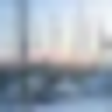

Name: 8, GT: ship
Method CE, classes = ['car'], confidences = [0.99731834], cl_platt = ['car'], conf_platt = [0.99317833]
Method CE+RT4U, classes = ['car' 'ship'], confidences = [0.84409241 0.09474205], cl_platt = ['car' 'ship'], conf_platt = [0.88804768 0.0718792 ]


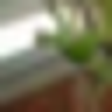

Name: 30, GT: frog
Method CE, classes = ['car' 'cat' 'dog' 'frog' 'truck'], confidences = [0.05955969 0.35826667 0.07249206 0.15834866 0.29995033], cl_platt = ['car' 'cat' 'dog' 'frog' 'truck'], conf_platt = [0.06957659 0.32907274 0.08248316 0.16226228 0.28214633]
Method CE+RT4U, classes = ['frog' 'truck'], confidences = [0.08154689 0.73784456], cl_platt = ['frog' 'truck'], conf_platt = [0.06453965 0.81165793]


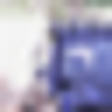

Name: 36, GT: car
Method CE, classes = ['truck'], confidences = [0.97769088], cl_platt = ['truck'], conf_platt = [0.95803817]
Method CE+RT4U, classes = ['car' 'truck'], confidences = [0.1383936  0.76730354], cl_platt = ['car' 'truck'], conf_platt = [0.11507099 0.82415717]


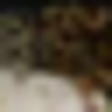

Name: 49, GT: dog
Method CE, classes = ['bird' 'cat' 'deer' 'dog' 'frog' 'horse'], confidences = [0.06884693 0.05369891 0.39268987 0.06902139 0.28323367 0.11567773], cl_platt = ['bird' 'cat' 'deer' 'dog' 'frog' 'horse'], conf_platt = [0.07916907 0.0638408  0.35759341 0.07934277 0.26946408 0.12408529]
Method CE+RT4U, classes = ['cat' 'deer' 'dog' 'frog'], confidences = [0.07972253 0.455136   0.1161337  0.23655595], cl_platt = ['cat' 'deer' 'dog' 'frog'], conf_platt = [0.06806068 0.50413774 0.1048807  0.23760621]


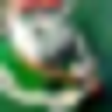

Name: 63, GT: ship
Method CE, classes = ['bird' 'cat' 'dog' 'frog' 'ship'], confidences = [0.11036627 0.1420007  0.15161896 0.51294383 0.06932187], cl_platt = ['bird' 'cat' 'dog' 'frog' 'ship'], conf_platt = [0.12190063 0.15163256 0.16048753 0.46113245 0.08149006]
Method CE+RT4U, classes = ['bird' 'cat' 'dog' 'frog' 'ship'], confidences = [0.25588239 0.08094974 0.07852123 0.42084774 0.09488281], cl_platt = ['bird' 'cat' 'dog' 'frog' 'ship'], conf_platt = [0.26304451 0.07006306 0.06765241 0.46603098 0.08409521]


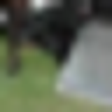

Name: 83, GT: horse
Method CE, classes = ['cat' 'deer' 'dog' 'horse'], confidences = [0.14398247 0.05552363 0.69711081 0.0713215 ], cl_platt = ['cat' 'deer' 'dog' 'horse'], conf_platt = [0.16052582 0.07033465 0.62913466 0.08736545]
Method CE+RT4U, classes = ['plane' 'cat' 'deer' 'dog' 'horse'], confidences = [0.12888218 0.07273787 0.14420667 0.3952572  0.19674414], cl_platt = ['plane' 'cat' 'deer' 'dog' 'horse'], conf_platt = [0.12089827 0.06263996 0.13756445 0.43838768 0.19660309]


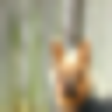

Name: 96, GT: dog
Method CE, classes = ['cat' 'deer' 'dog'], confidences = [0.85922983 0.04822547 0.07376186], cl_platt = ['cat' 'deer' 'dog'], conf_platt = [0.80366692 0.06635338 0.09587091]
Method CE+RT4U, classes = ['cat' 'deer' 'dog'], confidences = [0.46715661 0.30019938 0.12794653], cl_platt = ['cat' 'deer' 'dog'], conf_platt = [0.50631925 0.30455319 0.11426579]


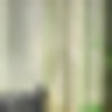

Name: 97, GT: dog
Method CE, classes = ['bird' 'cat' 'deer' 'frog'], confidences = [0.30266414 0.31134886 0.22929808 0.06327201], cl_platt = ['bird' 'cat' 'deer' 'frog'], conf_platt = [0.28417735 0.29122545 0.2234523  0.07327082]
Method CE+RT4U, classes = ['car' 'bird' 'cat' 'deer'], confidences = [0.09515176 0.1265778  0.57926719 0.11821397], cl_platt = ['car' 'bird' 'cat' 'deer'], conf_platt = [0.08136199 0.11295081 0.64885453 0.10441493]


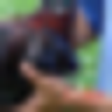

Name: 103, GT: bird
Method CE, classes = ['bird' 'cat' 'deer' 'dog' 'horse'], confidences = [0.10439468 0.23937697 0.16860957 0.28130379 0.20388202], cl_platt = ['bird' 'cat' 'deer' 'dog' 'horse'], conf_platt = [0.1142145  0.23433045 0.17299136 0.26948152 0.2039229 ]
Method CE+RT4U, classes = ['bird' 'deer' 'dog' 'horse'], confidences = [0.2664998  0.14733066 0.29730618 0.18791379], cl_platt = ['bird' 'deer' 'dog' 'horse'], conf_platt = [0.27920472 0.14126727 0.31661485 0.18685394]


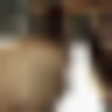

Name: 106, GT: deer
Method CE, classes = ['cat' 'dog' 'horse'], confidences = [0.22211057 0.41291842 0.31996248], cl_platt = ['cat' 'dog' 'horse'], conf_platt = [0.22920629 0.39213376 0.31442155]
Method CE+RT4U, classes = ['cat' 'deer' 'dog' 'horse'], confidences = [0.38925301 0.09059258 0.34500387 0.15722641], cl_platt = ['cat' 'deer' 'dog' 'horse'], conf_platt = [0.41062247 0.07685284 0.3574379  0.14483844]


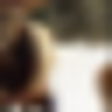

Name: 107, GT: deer
Method CE, classes = ['cat' 'deer' 'dog'], confidences = [0.05474748 0.06302545 0.87388053], cl_platt = ['cat' 'deer' 'dog'], conf_platt = [0.07484279 0.08454873 0.82416885]
Method CE+RT4U, classes = ['cat' 'deer' 'dog' 'horse'], confidences = [0.383512   0.16162372 0.3642112  0.08082246], cl_platt = ['cat' 'deer' 'dog' 'horse'], conf_platt = [0.4013161  0.14863316 0.3781888  0.06701197]


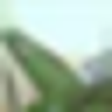

Name: 108, GT: plane
Method CE, classes = ['plane' 'truck'], confidences = [0.2388859  0.70791032], cl_platt = ['plane' 'truck'], conf_platt = [0.25685029 0.65802913]
Method CE+RT4U, classes = ['plane' 'horse' 'truck'], confidences = [0.14861426 0.08405084 0.55063798], cl_platt = ['plane' 'horse' 'truck'], conf_platt = [0.13793647 0.07164088 0.62160068]


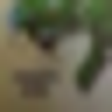

Name: 110, GT: plane
Method CE, classes = ['plane' 'bird' 'cat' 'dog' 'horse'], confidences = [0.16152931 0.22583503 0.36134894 0.11488313 0.0613146 ], cl_platt = ['plane' 'bird' 'cat' 'dog' 'horse'], conf_platt = [0.16326715 0.21824057 0.3278804  0.12154471 0.07056451]
Method CE+RT4U, classes = ['plane' 'bird' 'cat' 'deer' 'truck'], confidences = [0.13101455 0.26804984 0.1602053  0.11329732 0.20174053], cl_platt = ['plane' 'bird' 'cat' 'deer' 'truck'], conf_platt = [0.1280485  0.29157086 0.16135791 0.10835333 0.21031595]


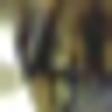

Name: 132, GT: dog
Method CE, classes = ['bird' 'cat' 'deer' 'dog' 'frog' 'horse'], confidences = [0.05378371 0.12842791 0.46714229 0.24530222 0.05389219 0.04806276], cl_platt = ['bird' 'cat' 'deer' 'dog' 'frog' 'horse'], conf_platt = [0.06509542 0.13832587 0.42319805 0.24226127 0.0652091  0.05905457]
Method CE+RT4U, classes = ['cat' 'deer' 'dog' 'frog'], confidences = [0.08186475 0.4348206  0.27590553 0.07462492], cl_platt = ['cat' 'deer' 'dog' 'frog'], conf_platt = [0.07064089 0.48158867 0.28549353 0.06350852]


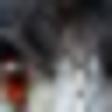

Name: 140, GT: bird
Method CE, classes = ['cat' 'dog' 'frog'], confidences = [0.56019217 0.29258513 0.0516183 ], cl_platt = ['cat' 'dog' 'frog'], conf_platt = [0.5093858  0.29024402 0.06460733]
Method CE+RT4U, classes = ['cat' 'deer' 'dog' 'frog' 'horse'], confidences = [0.37206398 0.11633482 0.1513676  0.1558729  0.10683447], cl_platt = ['cat' 'deer' 'dog' 'frog' 'horse'], conf_platt = [0.41623993 0.10938576 0.14803804 0.15311406 0.09918176]


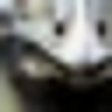

Name: 142, GT: bird
Method CE, classes = ['car' 'truck'], confidences = [0.92969351 0.053436  ], cl_platt = ['car' 'truck'], conf_platt = [0.89301395 0.07526419]
Method CE+RT4U, classes = ['car' 'ship' 'truck'], confidences = [0.74023093 0.07486728 0.0777513 ], cl_platt = ['car' 'ship' 'truck'], conf_platt = [0.80970055 0.05814369 0.06072563]


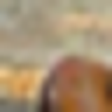

Name: 144, GT: deer
Method CE, classes = ['deer' 'horse'], confidences = [0.12813244 0.8198838 ], cl_platt = ['deer' 'horse'], conf_platt = [0.15368737 0.76684849]
Method CE+RT4U, classes = ['deer' 'horse'], confidences = [0.325047   0.48189406], cl_platt = ['deer' 'horse'], conf_platt = [0.33201588 0.52206747]


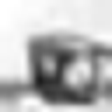

Name: 148, GT: car
Method CE, classes = ['car' 'truck'], confidences = [0.05235877 0.94007166], cl_platt = ['car' 'truck'], conf_platt = [0.07461281 0.90974073]
Method CE+RT4U, classes = ['plane' 'truck'], confidences = [0.07152959 0.82980774], cl_platt = ['plane' 'truck'], conf_platt = [0.05261905 0.88055797]


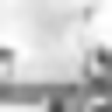

Name: 149, GT: car
Method CE, classes = ['plane' 'ship' 'truck'], confidences = [0.1089391  0.33936446 0.5317184 ], cl_platt = ['plane' 'ship' 'truck'], conf_platt = [0.12675726 0.33909819 0.50027346]
Method CE+RT4U, classes = ['ship' 'truck'], confidences = [0.367677   0.49192263], cl_platt = ['ship' 'truck'], conf_platt = [0.37517637 0.52428203]


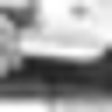

Name: 150, GT: car
Method CE, classes = ['plane' 'car' 'ship' 'truck'], confidences = [0.48619998 0.38481897 0.04926673 0.07564619], cl_platt = ['plane' 'car' 'ship' 'truck'], conf_platt = [0.46027762 0.37589877 0.06338642 0.09189101]
Method CE+RT4U, classes = ['plane' 'car' 'ship' 'truck'], confidences = [0.59970924 0.17763464 0.11253187 0.08247828], cl_platt = ['plane' 'car' 'ship' 'truck'], conf_platt = [0.65737061 0.16233363 0.09605524 0.067207  ]


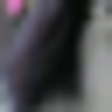

Name: 170, GT: dog
Method CE, classes = ['bird' 'cat' 'dog'], confidences = [0.08251112 0.54912984 0.32033192], cl_platt = ['bird' 'cat' 'dog'], conf_platt = [0.09822898 0.50709922 0.31796967]
Method CE+RT4U, classes = ['car' 'bird' 'cat' 'dog'], confidences = [0.09464126 0.08423745 0.45313249 0.29867077], cl_platt = ['car' 'bird' 'cat' 'dog'], conf_platt = [0.08171658 0.07147838 0.49445277 0.30621825]


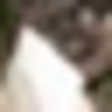

Name: 174, GT: frog
Method CE, classes = ['cat' 'dog' 'frog'], confidences = [0.46830381 0.25181199 0.24847577], cl_platt = ['cat' 'dog' 'frog'], conf_platt = [0.4398295  0.25700486 0.2540535 ]
Method CE+RT4U, classes = ['cat' 'dog' 'frog' 'horse'], confidences = [0.49506271 0.30799466 0.08631452 0.06916215], cl_platt = ['cat' 'dog' 'frog' 'horse'], conf_platt = [0.5357799  0.31049773 0.07194753 0.05577223]


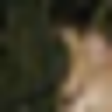

Name: 184, GT: cat
Method CE, classes = ['cat' 'deer' 'frog'], confidences = [0.20871503 0.61534669 0.16611243], cl_platt = ['cat' 'deer' 'frog'], conf_platt = [0.22464863 0.57298724 0.1843483 ]
Method CE+RT4U, classes = ['cat' 'deer' 'frog'], confidences = [0.26849929 0.5494512  0.14900691], cl_platt = ['cat' 'deer' 'frog'], conf_platt = [0.25891654 0.58970234 0.13158149]


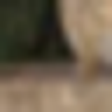

Name: 186, GT: cat
Method CE, classes = ['bird' 'cat' 'deer' 'dog' 'frog'], confidences = [0.16165674 0.16235155 0.08053406 0.53946085 0.05045193], cl_platt = ['bird' 'cat' 'deer' 'dog' 'frog'], conf_platt = [0.1720958  0.17273616 0.09412573 0.48865444 0.06278031]
Method CE+RT4U, classes = ['bird' 'cat' 'deer' 'dog' 'frog'], confidences = [0.12186564 0.16216984 0.39578125 0.15001531 0.15573324], cl_platt = ['bird' 'cat' 'deer' 'dog' 'frog'], conf_platt = [0.11191932 0.15543292 0.43346148 0.14211857 0.1483628 ]


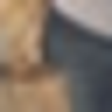

Name: 187, GT: cat
Method CE, classes = ['cat' 'dog'], confidences = [0.07352499 0.92277959], cl_platt = ['cat' 'dog'], conf_platt = [0.09971822 0.8916808 ]
Method CE+RT4U, classes = ['cat' 'dog'], confidences = [0.2865353  0.60687658], cl_platt = ['cat' 'dog'], conf_platt = [0.27468533 0.65084487]


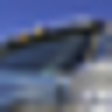

Name: 188, GT: truck
Method CE, classes = ['plane' 'ship' 'truck'], confidences = [0.80560736 0.09069488 0.08604988], cl_platt = ['plane' 'ship' 'truck'], conf_platt = [0.74766234 0.11279129 0.10777121]
Method CE+RT4U, classes = ['plane' 'ship'], confidences = [0.74253535 0.16618326], cl_platt = ['plane' 'ship'], conf_platt = [0.79783592 0.14275801]


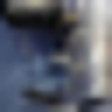

Name: 190, GT: truck
Method CE, classes = ['plane' 'car' 'ship' 'truck'], confidences = [0.04365893 0.41962567 0.14048451 0.32643298], cl_platt = ['plane' 'car' 'ship' 'truck'], conf_platt = [0.05447492 0.3866209  0.14987741 0.3110521 ]
Method CE+RT4U, classes = ['car' 'cat' 'ship' 'truck'], confidences = [0.15539967 0.32696273 0.16050612 0.22216215], cl_platt = ['car' 'cat' 'ship' 'truck'], conf_platt = [0.15213152 0.35773179 0.15789184 0.22942561]


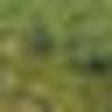

Name: 197, GT: frog
Method CE, classes = ['bird' 'deer' 'dog' 'horse'], confidences = [0.18292684 0.5448666  0.13510451 0.05790237], cl_platt = ['bird' 'deer' 'dog' 'horse'], conf_platt = [0.1887923  0.48582089 0.1452155  0.06971887]
Method CE+RT4U, classes = ['bird' 'deer' 'frog'], confidences = [0.23172202 0.4614899  0.13074161], cl_platt = ['bird' 'deer' 'frog'], conf_platt = [0.23247224 0.51320456 0.12041017]


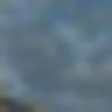

Name: 205, GT: ship
Method CE, classes = ['plane' 'bird' 'deer' 'ship'], confidences = [0.33897562 0.39867052 0.12370166 0.08647709], cl_platt = ['plane' 'bird' 'deer' 'ship'], conf_platt = [0.32079939 0.36918071 0.13400091 0.09828062]
Method CE+RT4U, classes = ['plane' 'bird' 'deer' 'ship'], confidences = [0.41779993 0.13683506 0.15392652 0.22581288], cl_platt = ['plane' 'bird' 'deer' 'ship'], conf_platt = [0.45746613 0.1268011  0.14517107 0.22552492]


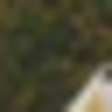

Name: 208, GT: plane
Method CE, classes = ['plane' 'bird' 'cat' 'dog' 'horse'], confidences = [0.06477572 0.2666028  0.05371814 0.24678113 0.27997598], cl_platt = ['plane' 'bird' 'cat' 'dog' 'horse'], conf_platt = [0.07356193 0.25047531 0.06255405 0.23426556 0.26131993]
Method CE+RT4U, classes = ['bird' 'dog' 'horse'], confidences = [0.45388943 0.18024923 0.15411248], cl_platt = ['bird' 'dog' 'horse'], conf_platt = [0.51209151 0.17714008 0.14794867]


In [31]:
def get_CIFAR_image_by_id(uid, training_set=True):
    image_id = uid // 4
    if training_set:
        img_full, _ = cifar_10_tr[image_id]
        img_quad = cifar_Q_tr[uid]['x']
    else:
        img_full, _ = cifar_10_te[image_id]
        img_quad = cifar_Q_te[uid]['x']
    return img_full, img_quad

def plot_cifar_inference(index):
    name = df_test[0]['filename'][index]
    img_full, img_quad = get_CIFAR_image_by_id(name, False)
    #img_full.resize((112,112)).show()
    img_quad.resize((112,112)).show()
    show_inference_data(index, True)
    

count = 0
for i in selected:
    if count < 30:
        plot_cifar_inference(i)
        count += 1 